
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online[![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/v0.20?urlpath=lab/tree/tutorials/analysis/2D/modeling_2D.ipynb)
- You may download all the notebooks as a [tar file](../../../_downloads/notebooks-0.20.tar).
- **Source files:**
[modeling_2D.ipynb](../../../_static/notebooks/modeling_2D.ipynb) |
[modeling_2D.py](../../../_static/notebooks/modeling_2D.py)
</div>


# 2D map fitting

## Prerequisites
 - To understand how a generel modelling and fiiting works in gammapy, please refer to the [analysis_3d tutorial](../3D/analysis_3d.ipynb)

## Context
We often want the determine the position and morphology of an object. To do so, we don't necessarily have to resort to a full 3D fitting but can perform a simple image fitting, in particular, in an energy range where the PSF does not vary strongly, or if we want to explore a possible energy dependence of the morphology.


## Objective
To localize a source and/or constrain its morphology.

## Proposed approach

The first step here, as in most analysis with DL3 data, is to create reduced datasets. For this, we will use the `Analysis` class to create a single set of stacked maps with a single bin in energy (thus, an *image* which behaves as a *cube*). This, we will then model with a spatial model of our choice, while keeping the spectral model fixed to an integrated power law.

## Setup
As usual, we'll start with some general imports...

In [1]:
%matplotlib inline
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time

import logging

log = logging.getLogger(__name__)

Now let's import gammapy specific classes and functions

In [2]:
from gammapy.analysis import Analysis, AnalysisConfig

## Creating the config file

Now, we create a config file for out analysis. You may load this from disc if you have a pre-defined config file.

Here, we use 3 simulated CTA runs of the galactic center.

In [3]:
config = AnalysisConfig()
# Selecting the observations
config.observations.datastore = "$GAMMAPY_DATA/cta-1dc/index/gps/"
config.observations.obs_ids = [110380, 111140, 111159]

Technically, gammapy implements 2D analysis as a special case of 3D analysis (one one bin in energy). So, we must specify the type of analysis as *3D*, and define the geometry of the analysis.

In [4]:
config.datasets.type = "3d"
config.datasets.geom.wcs.skydir = {
    "lon": "0 deg",
    "lat": "0 deg",
    "frame": "galactic",
}  # The WCS geometry - centered on the galactic center
config.datasets.geom.wcs.width = {"width": "8 deg", "height": "6 deg"}
config.datasets.geom.wcs.binsize = "0.02 deg"

# The FoV radius to use for cutouts
config.datasets.geom.selection.offset_max = 2.5 * u.deg
config.datasets.safe_mask.methods = ["offset-max"]
config.datasets.safe_mask.parameters = {"offset_max": 2.5 * u.deg}
config.datasets.background.method = "fov_background"
config.fit.fit_range = {"min": "0.1 TeV", "max": "30.0 TeV"}

# We now fix the energy axis for the counts map - (the reconstructed energy binning)
config.datasets.geom.axes.energy.min = "0.1 TeV"
config.datasets.geom.axes.energy.max = "10 TeV"
config.datasets.geom.axes.energy.nbins = 1

config.datasets.geom.wcs.binsize_irf = 0.2 * u.deg

In [5]:
print(config)

AnalysisConfig

    general:
        log: {level: info, filename: null, filemode: null, format: null, datefmt: null}
        outdir: .
        n_jobs: 1
        datasets_file: null
        models_file: null
    observations:
        datastore: $GAMMAPY_DATA/cta-1dc/index/gps
        obs_ids: [110380, 111140, 111159]
        obs_file: null
        obs_cone: {frame: null, lon: null, lat: null, radius: null}
        obs_time: {start: null, stop: null}
        required_irf: [aeff, edisp, psf, bkg]
    datasets:
        type: 3d
        stack: true
        geom:
            wcs:
                skydir: {frame: galactic, lon: 0.0 deg, lat: 0.0 deg}
                binsize: 0.02 deg
                width: {width: 8.0 deg, height: 6.0 deg}
                binsize_irf: 0.2 deg
            selection: {offset_max: 2.5 deg}
            axes:
                energy: {min: 0.1 TeV, max: 10.0 TeV, nbins: 1}
                energy_true: {min: 0.5 TeV, max: 20.0 TeV, nbins: 16}
        map_selection: [

## Getting the reduced dataset

We now use the config file and create a single `MapDataset` containing `counts`, `background`, `exposure`, `psf` and `edisp` maps.

In [6]:
%%time
analysis = Analysis(config)
analysis.get_observations()
analysis.get_datasets()

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}
Fetching observations.
Observations selected: 3 out of 3.
Number of selected observations: 3
Creating reference dataset and makers.
Creating the background Maker.
Start the data reduction loop.
Computing dataset for observation 110380
Running MapDatasetMaker
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Running SafeMaskMaker
Running FoVBackgroundMaker
Computing dataset for observation 111140
Running MapDatasetMaker
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Running SafeMaskMaker
Running FoVBackgroundMaker
Computing dataset for observation 111159
Running MapDatasetMaker
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Running SafeMaskMaker
Running FoVBackgroundMaker


CPU times: user 5.35 s, sys: 1.04 s, total: 6.38 s
Wall time: 8.63 s


In [7]:
print(analysis.datasets["stacked"])

MapDataset
----------

  Name                            : stacked 

  Total counts                    : 85625 
  Total background counts         : 85624.99
  Total excess counts             : 0.01

  Predicted counts                : 85625.00
  Predicted background counts     : 85624.99
  Predicted excess counts         : nan

  Exposure min                    : 8.46e+08 m2 s
  Exposure max                    : 2.14e+10 m2 s

  Number of total bins            : 120000 
  Number of fit bins              : 96602 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




The counts and background maps have only one bin in reconstructed energy. The exposure and IRF maps are in true energy, and hence, have a different binning based upon the binning of the IRFs. We need not bother about them presently.

In [8]:
analysis.datasets["stacked"].counts

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (400, 300, 1)
	ndim  : 3
	unit  : 
	dtype : float32

In [9]:
analysis.datasets["stacked"].background

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (400, 300, 1)
	ndim  : 3
	unit  : 
	dtype : float32

In [10]:
analysis.datasets["stacked"].exposure

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy_true']
	shape : (400, 300, 16)
	ndim  : 3
	unit  : m2 s
	dtype : float32

We can have a quick look of these maps in the following way:

<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

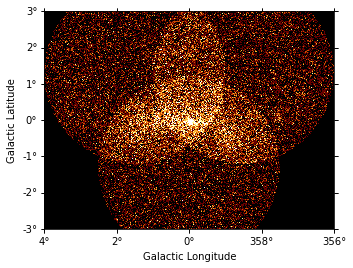

In [11]:
analysis.datasets["stacked"].counts.reduce_over_axes().plot(vmax=5)

## Modelling

Now, we define a model to be fitted to the dataset. **The important thing to note here is the dummy spectral model - an integrated powerlaw with only free normalisation**. Here, we use its YAML definition to load it:

In [12]:
model_config = """
components:
- name: GC-1
  type: SkyModel
  spatial:
    type: PointSpatialModel
    frame: galactic
    parameters:
    - name: lon_0
      value: 0.02
      unit: deg
    - name: lat_0 
      value: 0.01    
      unit: deg
  spectral:
    type: PowerLaw2SpectralModel
    parameters:
    - name: amplitude      
      value: 1.0e-12
      unit: cm-2 s-1 
    - name: index
      value: 2.0
      unit: ''
      frozen: true
    - name: emin
      value: 0.1
      unit: TeV
      frozen: true
    - name: emax
      value: 10.0
      unit: TeV
      frozen: true 
"""

In [13]:
analysis.set_models(model_config)

Reading model.
Models

Component 0: SkyModel

  Name                      : GC-1
  Datasets names            : None
  Spectral model type       : PowerLaw2SpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s) 
    index                 (frozen):      2.000                   
    emin                  (frozen):      0.100       TeV         
    emax                  (frozen):     10.000       TeV         
    lon_0                         :      0.020   +/-    0.00 deg         
    lat_0                         :      0.010   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : stacked-bkg
  Datasets names            : ['stacked']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000          

We will freeze the parameters of the background

In [14]:
analysis.datasets["stacked"].background_model.parameters["tilt"].frozen = True

In [15]:
# To run the fit
analysis.run_fit()

Fitting datasets.
OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 184
	total stat : 170089.04

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [16]:
# To see the best fit values along with the errors
analysis.models.to_parameters_table()

<Table length=9>
   model      type      name      value      unit     error      min        max    frozen is_norm link
   str11      str8      str9     float64     str8    float64   float64    float64   bool    bool  str1
----------- -------- --------- ----------- -------- --------- ---------- --------- ------ ------- ----
       GC-1 spectral amplitude  4.1800e-11 cm-2 s-1 2.231e-12        nan       nan  False    True     
       GC-1 spectral     index  2.0000e+00          0.000e+00        nan       nan   True   False     
       GC-1 spectral      emin  1.0000e-01      TeV 0.000e+00        nan       nan   True   False     
       GC-1 spectral      emax  1.0000e+01      TeV 0.000e+00        nan       nan   True   False     
       GC-1  spatial     lon_0 -5.4767e-02      deg 1.993e-03        nan       nan  False   False     
       GC-1  spatial     lat_0 -5.3629e-02      deg 1.981e-03 -9.000e+01 9.000e+01  False   False     
stacked-bkg spectral      norm  9.9438e-01          3.411e-03        nan       nan  False    True     
stacked-bkg spectral      tilt  0.0000e+00          0.000e+00        nan       nan   True   False     
stacked-bkg spectral reference  1.0000e+00      TeV 0.000e+00        nan       nan   True   False